In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os
from pathlib import Path
import cv2
import shutil 

In [14]:
path = Path(os.getcwd()+"\\data\\BdSl")
path.ls()

[WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/codes.txt'),
 WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/images'),
 WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/labels'),
 WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/valid.txt')]

In [15]:
path_lbl = path/'labels'
path_img = path/'images'
path_val = path/'validation'

In [16]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/images/A10_frame_0.png'),
 WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/images/A10_frame_1.png'),
 WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/images/A10_frame_10.png')]

In [17]:
# with open("label.csv", "w") as f1:
#         for line in lbl_names:
#             f1.write(str(line)+"\n")

In [18]:
# with open("codes.txt", "w") as f1:
#         for i in range(1,255):
#             f1.write("Hand"+"\n")

In [19]:
# f or line in range(0,len(fnames),20):
#     f = "E:\\STUDY\\fastai\\Pytorch\\data\\validation\\"+(os.path.split(fnames[line]))[1]
#     shutil.move(fnames[line],f)

In [20]:
# with open("valid.txt", "w") as f1:
#         for line in range(0,len(fnames),20):
#             f1.write(str(os.path.split(fnames[line])[1])+"\n")

In [21]:
# df = pd.read_csv('label.csv', header=None)
# df[0][1]

In [22]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/labels/A10_frame_0.png'),
 WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/labels/A10_frame_1.png'),
 WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/labels/A10_frame_10.png')]

('E:\\STUDY\\fastai\\Pytorch\\data\\BdSl\\images', 'A10_frame_0.png')


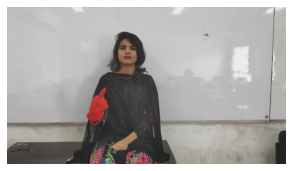

In [23]:
img_f = fnames[0]
print(os.path.split(img_f))
img = open_image(img_f)
img.show(figsize=(5,5))

In [24]:
get_y_fn = lambda x: path_lbl/os.path.split(x)[1]
#get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

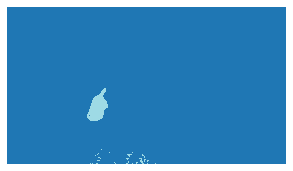

In [25]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [26]:
src_size = np.array(mask.shape[1:])
src_size,torch.unique(mask.data)

(array([1080, 1920]), tensor([0, 1]))

In [27]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['non-hand', 'Hand'], dtype='<U8')

In [28]:
size = [128,128]

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")
size

using bs=4, have 1015MB of GPU RAM free


[128, 128]

In [29]:
func = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [30]:
func(img_f)

WindowsPath('E:/STUDY/fastai/Pytorch/data/BdSl/labels/A10_frame_0.png')

In [31]:
src = SegmentationItemList.from_folder(path=path_img)
src = src.split_by_fname_file('../valid.txt')
src = src.label_from_func(get_y_fn, classes=codes)


In [32]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

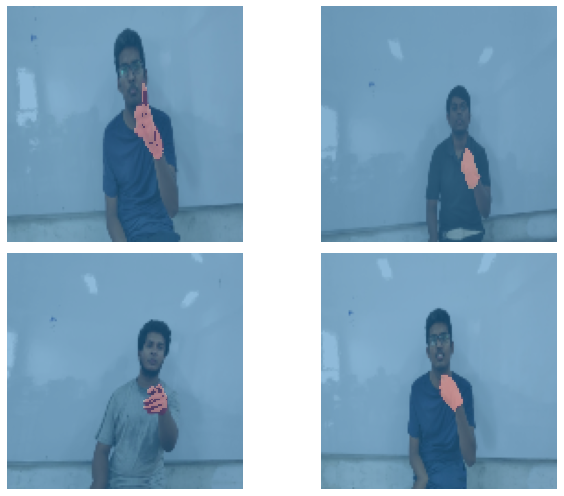

In [21]:
data.show_batch(2, figsize=(10,7))

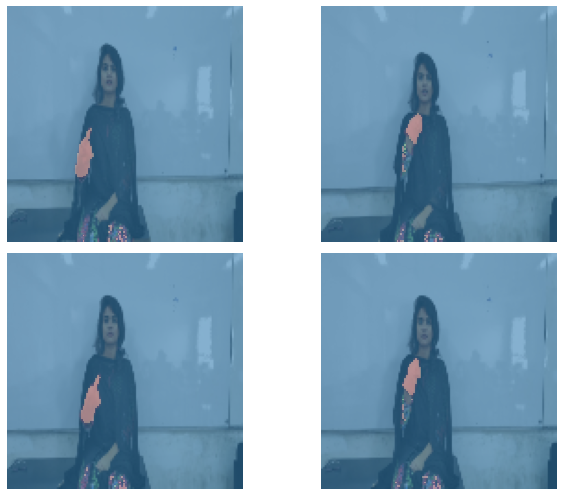

In [22]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [25]:
# name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [34]:
#metrics=acc_camvid
metrics=accuracy

In [35]:
wd=1e-2

In [36]:
learn = unet_learner(data, models.resnet34, metrics=[dice], wd=wd)

In [29]:
#defaults.device = torch.device('cpu')

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


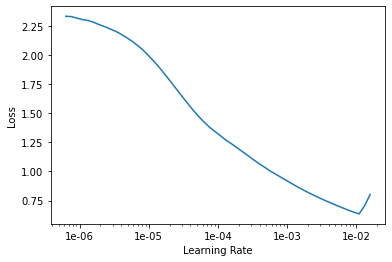

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr=3e-3

In [27]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.003199,0.002806,0.940465,03:20
1,0.002596,0.002275,0.949146,03:21
2,0.002424,0.002417,0.949927,03:30
3,0.002243,0.001730,0.963592,03:30
4,0.002092,0.001706,0.963060,03:28
5,0.001837,0.001616,0.964240,03:40
6,0.001743,0.001587,0.964880,03:56
7,0.001722,0.001544,0.965882,03:54
8,0.001513,0.001456,0.967170,03:42
9,0.001538,0.001468,0.967176,03:29


In [28]:
learn.save('stage-1')

In [37]:
learn.load('stage-1');

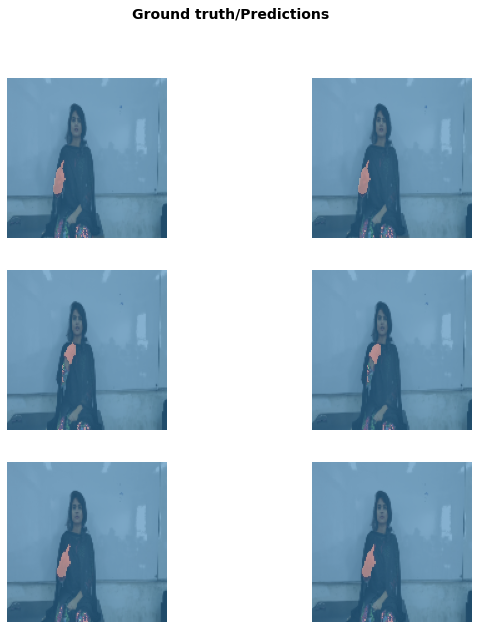

In [39]:
learn.show_results(rows=3, figsize=(10,10))

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(lr/400,lr/4)

In [42]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.001548,0.001466,0.967151,04:01
1,0.001624,0.001455,0.967339,04:22
2,0.001491,0.001446,0.967696,04:07
3,0.001500,0.001445,0.967587,04:08
4,0.001639,0.001461,0.968060,04:09
5,0.001525,0.001434,0.968125,04:30
6,0.001507,0.001443,0.968057,04:32
7,0.001635,0.001481,0.966354,04:02
8,0.001577,0.001448,0.966367,04:06
9,0.001549,0.001476,0.967062,04:06


In [43]:
learn.save('stage-2');

In [44]:
learn.load('stage-1');

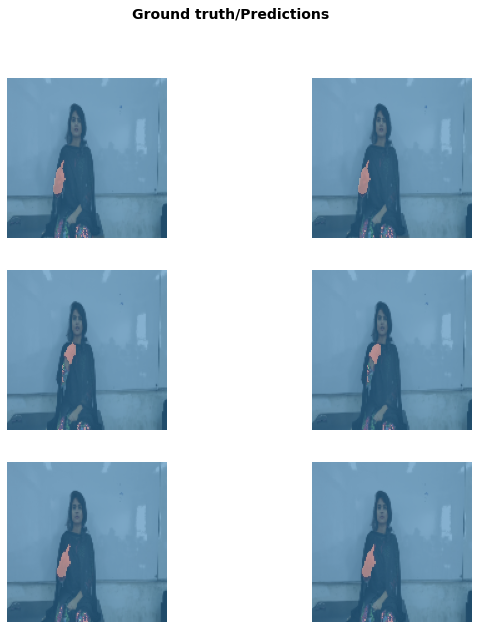

In [48]:
learn.show_results(rows=3, figsize=(10,10))

# With Bigger Image Size

In [13]:
#learn.destroy()

size = [256,256]

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 4021MB of GPU RAM free


In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [20]:
learn = unet_learner(data, models.resnet34, metrics=[dice], wd=wd)

In [21]:
learn.load('stage-2');

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


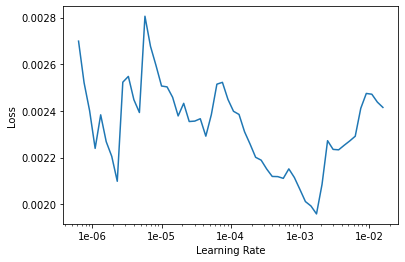

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=1e-4

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.002042,0.001629,0.963911,25:38
1,0.001403,0.001497,0.966615,11:11
2,0.001528,0.001409,0.968508,11:30
3,0.001381,0.001360,0.969892,11:46
4,0.001357,0.001339,0.970600,11:21
5,0.001335,0.001279,0.971537,11:41
6,0.001315,0.001280,0.971227,11:40
7,0.001325,0.001266,0.971749,11:27
8,0.001260,0.001276,0.972023,12:00
9,0.001282,0.001244,0.972535,11:58


In [25]:
learn.save('stage-1-big')

In [26]:
learn.load('stage-1-big');

In [27]:
learn.unfreeze()

In [28]:
lrs = slice(1e-6,lr/10)

In [29]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,dice,time
0,0.001303,0.001308,0.971184,13:02
1,0.001359,0.001219,0.973208,13:18
2,0.001207,0.001263,0.972296,13:15
3,0.001128,0.001224,0.973138,13:21
4,0.001097,0.001277,0.971453,13:20
5,0.001235,0.001261,0.972292,13:22
6,0.001270,0.001247,0.972595,13:32
7,0.001282,0.001228,0.972991,13:24
8,0.001071,0.001235,0.972906,16:12
9,0.001209,0.001251,0.971954,19:47


In [30]:
learn.save('stage-2-big')

In [31]:
learn.load('stage-2-big');

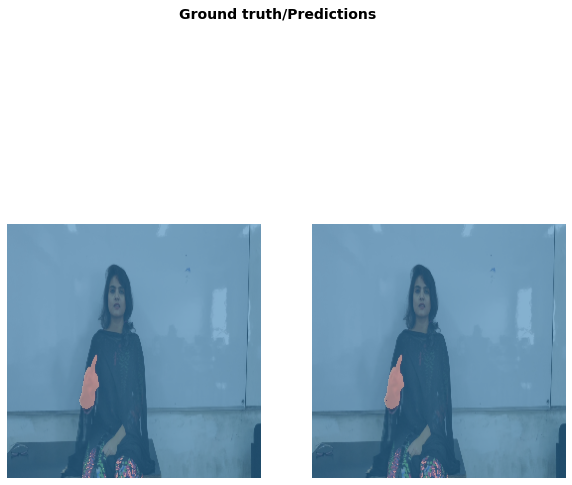

In [32]:
learn.show_results(rows=3, figsize=(10,10))

In [37]:
defaults.device = torch.device('cpu')

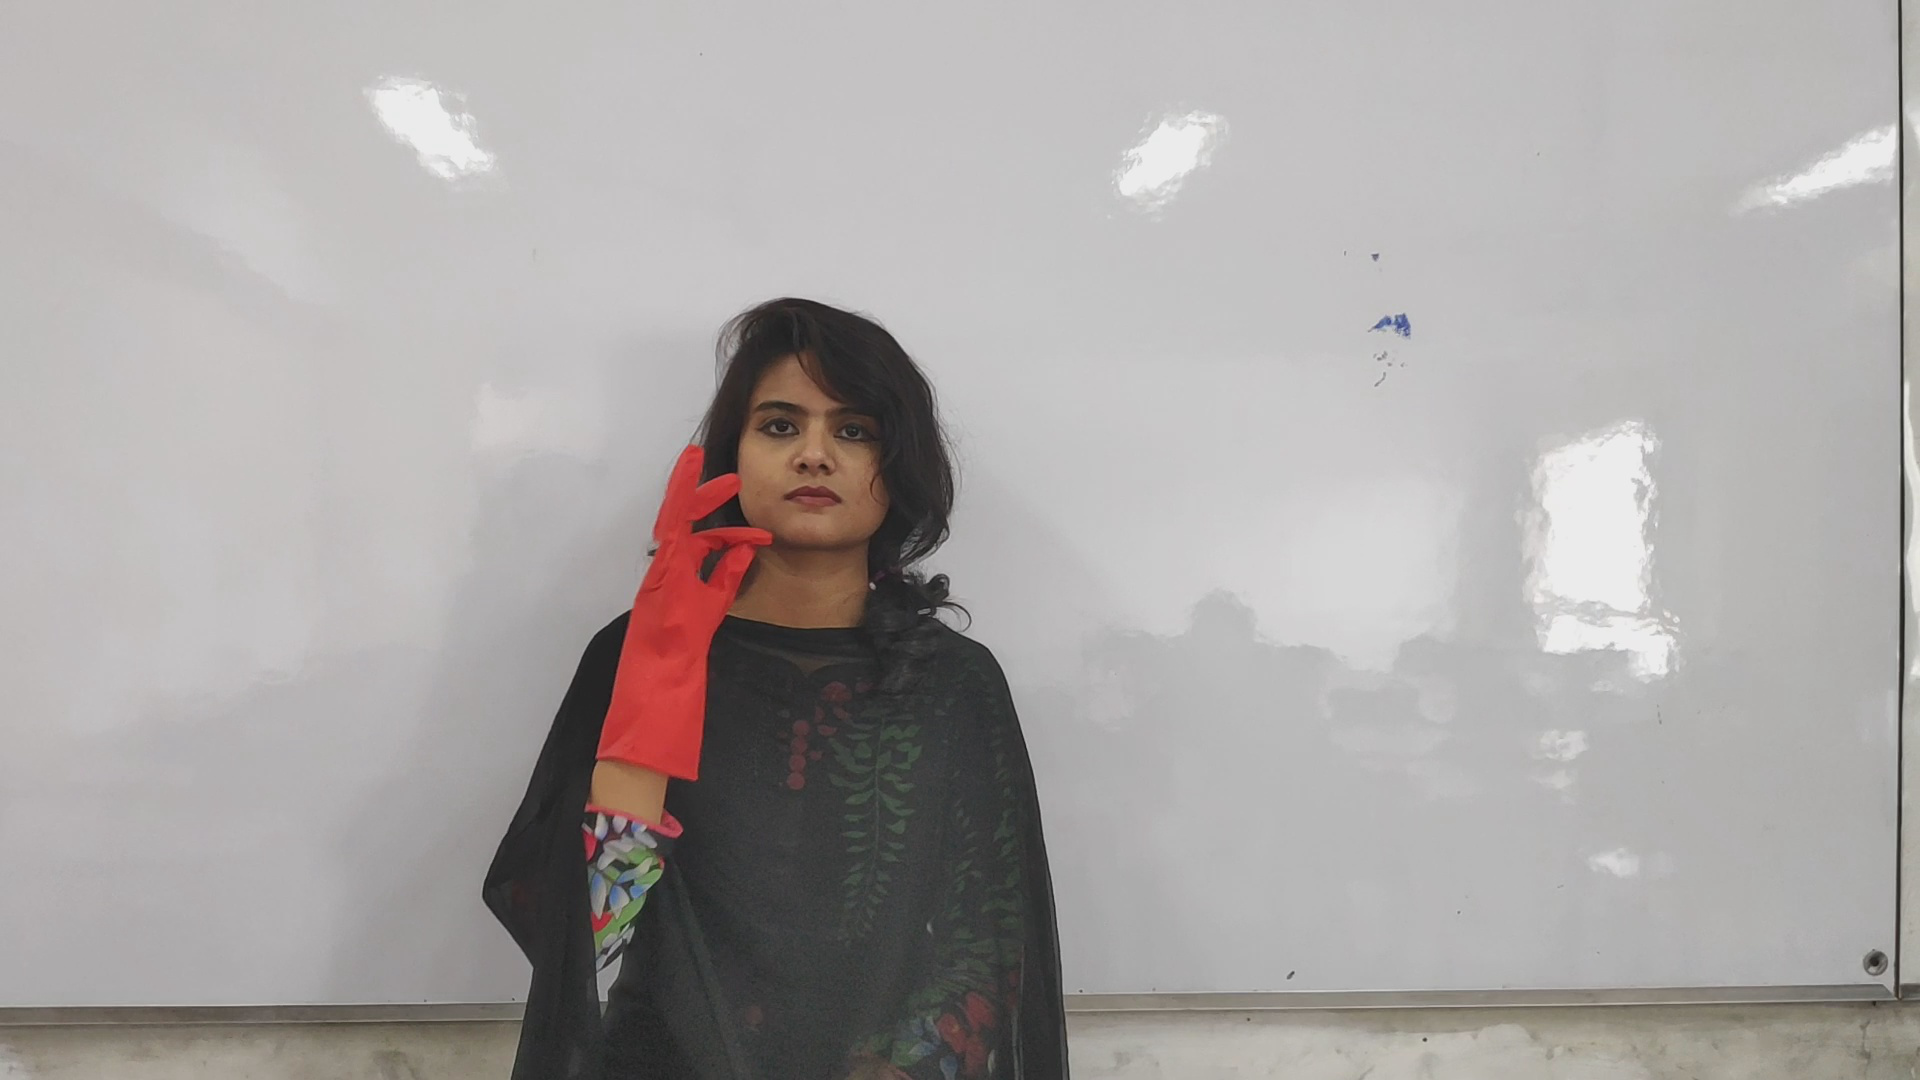

In [39]:
img = open_image("E:\\STUDY\\fastai\\Pytorch\\check.png")
img

In [40]:
learn.load('stage-2-big');

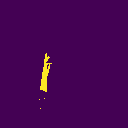

In [41]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

In [42]:
import cv2 as cv
from PIL import Image
from torchvision import transforms
from numpy import asarray
im_color = cv.imread("E:\\STUDY\\fastai\\Pytorch\\check.png")
im_color = cv.resize(im_color, (128,128), interpolation = cv2.INTER_AREA)


In [43]:
img3 = np.zeros((128,128,3))
#pred_idx[)][1][5]
for i in range(128):
    for j in range(128):
        for k in range(3):
            img3[i][j][k] = pred_idx[0][i][j]*im_color[i][j][k]

In [44]:
cv2.imwrite('cv2.png',img3)

True

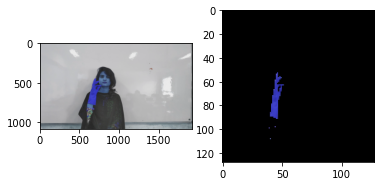

In [45]:
import matplotlib.pyplot as plt

# read images
img_A = cv2.imread("E:\\STUDY\\fastai\\Pytorch\\check.png")
img_B = cv2.imread("E:\\STUDY\\fastai\\Pytorch\\cv2.png")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);